# Imports

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import glob
import random
import cv2
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Data handling block

In [14]:
IMG_SIZE = 299
GPU = True
DATA_PATH = "C:/Users/Cerberus/Documents/ML/Project/dataset299"

print("Data path: ",DATA_PATH)
print("Image size: ",IMG_SIZE)
print("GPU enabled: ",GPU)

if GPU == True:
    torch.cuda.set_device(0)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

emotions = ["anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"] #Emotion list
#emotions = ["fear", "happy","surprise"] #Emotion list

def get_files(emotion): #Define function to get file list, randomly shuffle it and split 60/40
    files = glob.glob("C:/Users/Cerberus/Documents/ML/Project/dataset299//%s//*" %emotion)
    random.shuffle(files)
    training = files[:int(len(files)*0.6)] #get first 60% of file list
    prediction = files[-int(len(files)*0.4):] #get last 40% of file list
    return training, prediction

def generateEmotionDataset():
    td = []
    tl = []
    pd = []
    pl = []
    for emotion in emotions:
        training, prediction = get_files(emotion)
        #Append data to training and prediction list, and generate labels 0-7
        for item in training:
            #image = cv2.imread(item) #open image
            #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convert to grayscale
            td.append(item) #append image array to training data list
            tl.append(emotions.index(emotion))

        for item in prediction: #repeat above process for prediction set
            #image = cv2.imread(item)
            #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            pd.append(item)
            pl.append(emotions.index(emotion))
       
    data_t= {}
    for i in range(len(td)):
        data_t[td[i]] = tl[i]
    
    data_p= {}
    for i in range(len(pd)):
        data_p[pd[i]] = pl[i]
        
    #randomize
    keys_t =  list(data_t.keys())      # Python 3; use keys = d.keys() in Python 2
    random.shuffle(keys_t)
    keys_p =  list(data_p.keys())      # Python 3; use keys = d.keys() in Python 2
    random.shuffle(keys_p)

    training_data = []
    training_labels = []
        #LOAD data
    for k in keys_t:
        image = cv2.imread(k)
        #gray = cv2.cvtColor(image,cv2.COLOR_RGB)
        training_data.append(image)
        training_labels.append(data_t[k])
    
    prediction_data = []
    prediction_labels = []
    #LOAD data
    for k in keys_p:
        image = cv2.imread(k)
        #gray = cv2.cvtColor(image,cv2.COLOR_RGB)
        prediction_data.append(image)
        prediction_labels.append(data_p[k])
    return training_data, training_labels, prediction_data, prediction_labels

# Need a RGB image
class data_loader_3D(torch.utils.data.Dataset):
    def __init__(self, images_input,label_output):
        Images, Y = [], []
        
        for i in range(len(images_input)):
            Images.append(images_input[i])
            Y.append(label_output[i])

        data = [(x, y) for x, y in zip(Images, Y)]
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index][0]      
        #img = img.reshape(3, 299, 299)
        img_tensor = transforms.ToTensor()(img)
        img_tensor.view(3, 299, 299).float()
        label = self.data[index][1]
        return (img_tensor, label)

Data path:  C:/Users/Cerberus/Documents/ML/Project/dataset299
Image size:  299
GPU enabled:  True
cuda:0


# Stats block

In [15]:
def get_label_quantity(label_set):
    myset = set(label_set)
    labels = np.zeros(len(myset))
    for i in range(len(label_set)):
        labels[label_set[i]] += 1 
    return labels

def get_accuracy_batch(model,dataset):
    correct=0
    batch_size = -1
    for _, data in enumerate(dataset, 0):
        test_x, test_y = data
        
        if GPU == True:
            test_x, test_y = test_x.cuda(), test_y.cuda()
            
        pred, aux =model.forward(test_x)
        
        if batch_size == -1:
            batch_size = len(pred.data)
        
        for i in range(len(pred.data)):
            y_hat=np.argmax(pred.data[i])

            if test_y[i].item()==y_hat.item():
                correct+=1
            
    return correct/(len(dataset)*batch_size)

def get_stats_batch(model,dataset):
    actu_all = []
    pred_all = []

    for _, data in enumerate(dataset, 0):
        test_x, test_y = data
        if GPU == True:
            test_x, test_y = test_x.cuda(), test_y.cuda()
        
        pred,aux=model.forward(test_x)
        
        if GPU == True:
            test_y = test_y.cpu()
            pred = pred.cpu()
        
        test_y = test_y.numpy()
        for i in range(len(pred.data)):   
            pred_all.append(np.argmax(pred.data[i].numpy()))
            actu_all.append(test_y[i])


    df_confusion = confusion_matrix(actu_all,pred_all)
    stats = classification_report(actu_all, pred_all)
    return df_confusion,stats

def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    
    # Begin CHANGES
    fst_empty_cell = (columnwidth-3)//2 * " " + "t/p" + (columnwidth-3)//2 * " "
    
    if len(fst_empty_cell) < len(empty_cell):
        fst_empty_cell = " " * (len(empty_cell) - len(fst_empty_cell)) + fst_empty_cell
    # Print header
    print("    " + fst_empty_cell, end=" ")
    # End CHANGES
    
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
        
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}i".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

# Data loading block

In [16]:
training_data_emo, training_labels_emo, prediction_data_emo, prediction_labels_emo = generateEmotionDataset()    

train_dataset_emo_3D = data_loader_3D(training_data_emo,training_labels_emo)
train_loader_emo_3D = torch.utils.data.DataLoader(dataset=train_dataset_emo_3D, batch_size=8, shuffle=True)
test_dataset_emo_3D = data_loader_3D(prediction_data_emo,prediction_labels_emo)
test_loader_emo_3D = torch.utils.data.DataLoader(test_dataset_emo_3D, batch_size=8, shuffle=True)
print("Training: ",get_label_quantity(training_labels_emo))
print("Testing: ",get_label_quantity(prediction_labels_emo))
print("Sum Training: ", np.sum(get_label_quantity(training_labels_emo)))
print("Sum Testing: ", np.sum(get_label_quantity(prediction_labels_emo)))

Training:  [27. 10. 35. 15. 41. 16. 48.]
Testing:  [18.  7. 23. 10. 27. 11. 32.]
Sum Training:  192.0
Sum Testing:  128.0


# Model and training definition

In [17]:
model_conv = torchvision.models.inception_v3(pretrained='imagenet')
model_conv.aux_logit=False

freeze_layers = True
n_class = len(get_label_quantity(prediction_labels_emo))
print("# class => ",n_class)

## Lets freeze the first few layers. This is done in two stages 
# Stage-1 Freezing all the layers 
if freeze_layers == True:
    for i, param in model_conv.named_parameters():
        param.requires_grad = False

# Since imagenet as 1000 classes ,
#We need to change our last layer according to the number of classes we have,
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, n_class)


# Stage-2 , Freeze all the layers but the one we want "Conv2d_4a_3*3"
for name, child in model_conv.named_children():
    if "" == name:
        for params in child.parameters():
            params.requires_grad = True

    
# To view which layers are freeze and which layers are not freezed:
for name, child in model_conv.named_children():
    print(name)
    for name_2, params in child.named_parameters():
        print(name_2, params.requires_grad)
    print('-' * 10)
    
print(model_conv.fc.out_features)

def trainClassifier(net,train_set,test_set,criterion,optimizer,epochs,volubile=False):
    history = []
    for epoch in range(1, epochs+1):
        print('Epoch {}/{}'.format(epoch, epochs))
        print('-' * 10)
        
        for step, data in enumerate(train_set, 0):
            train_x, train_y = data
            #IF GPU
            train_x, train_y = train_x.cuda(), train_y.cuda()
            #print(train_y)
            y_hat, aux = net(train_x)
            

            #train_y = torch.LongTensor(np.array(train_y))
            
            
            
            loss = criterion(y_hat, train_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        history.append(loss.item())
        if volubile == True:  
            epoch_training_acc = get_accuracy_batch(net,train_set)
            print('{} -> Acc: {:.4f}'.format("training",epoch_training_acc))
            epoch_testing_acc = get_accuracy_batch(net,test_set)
            print('{} -> Acc: {:.4f}'.format("testing", epoch_testing_acc))  
    
    return net, history

# class =>  7
Conv2d_1a_3x3
conv.weight False
bn.weight False
bn.bias False
----------
Conv2d_2a_3x3
conv.weight False
bn.weight False
bn.bias False
----------
Conv2d_2b_3x3
conv.weight False
bn.weight False
bn.bias False
----------
Conv2d_3b_1x1
conv.weight False
bn.weight False
bn.bias False
----------
Conv2d_4a_3x3
conv.weight False
bn.weight False
bn.bias False
----------
Mixed_5b
branch1x1.conv.weight False
branch1x1.bn.weight False
branch1x1.bn.bias False
branch5x5_1.conv.weight False
branch5x5_1.bn.weight False
branch5x5_1.bn.bias False
branch5x5_2.conv.weight False
branch5x5_2.bn.weight False
branch5x5_2.bn.bias False
branch3x3dbl_1.conv.weight False
branch3x3dbl_1.bn.weight False
branch3x3dbl_1.bn.bias False
branch3x3dbl_2.conv.weight False
branch3x3dbl_2.bn.weight False
branch3x3dbl_2.bn.bias False
branch3x3dbl_3.conv.weight False
branch3x3dbl_3.bn.weight False
branch3x3dbl_3.bn.bias False
branch_pool.conv.weight False
branch_pool.bn.weight False
branch_pool.bn.bias False
---

branch3x3dbl_1.bn.weight False
branch3x3dbl_1.bn.bias False
branch3x3dbl_2.conv.weight False
branch3x3dbl_2.bn.weight False
branch3x3dbl_2.bn.bias False
branch3x3dbl_3a.conv.weight False
branch3x3dbl_3a.bn.weight False
branch3x3dbl_3a.bn.bias False
branch3x3dbl_3b.conv.weight False
branch3x3dbl_3b.bn.weight False
branch3x3dbl_3b.bn.bias False
branch_pool.conv.weight False
branch_pool.bn.weight False
branch_pool.bn.bias False
----------
fc
weight True
bias True
----------
7


# Train the model updating the wieghts only on the last layer

In [18]:
epochs=100
if GPU == True:
    model_conv.cuda()

criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model_conv.parameters())
#optimizer = torch.optim.Adam(model_conv.parameters(), 1.0, (0.9, 0.999), 1.0, 5e-05)
#optimizer = torch.optim.Adagrad(model_conv.parameters(), 1.0, 0, 0.1,0)
#optimizer = torch.optim.ASGD(model_conv.parameters(), 0.1, 0.0001, 0.75, 1000000.0, 0)
optimizer = torch.optim.Adadelta(model_conv.parameters(), 1.0, 0.9, 1e-06, 5e-05)
#optimizer = torch.optim.SGD(model_conv.parameters(),lr=1e-3, momentum=0.9, dampening=0)


classifier_emo,loss_history_emo = trainClassifier(model_conv,train_loader_emo_3D,test_loader_emo_3D,criterion,optimizer,epochs,True)

acc_emo = get_accuracy_batch(classifier_emo,test_loader_emo_3D)
confmat_emo, stats_emo = get_stats_batch(classifier_emo,test_loader_emo_3D)

Epoch 1/100
----------
training -> Acc: 0.1719
testing -> Acc: 0.1562
Epoch 2/100
----------
training -> Acc: 0.3698
testing -> Acc: 0.2891
Epoch 3/100
----------
training -> Acc: 0.6042
testing -> Acc: 0.5703
Epoch 4/100
----------
training -> Acc: 0.5573
testing -> Acc: 0.5000
Epoch 5/100
----------
training -> Acc: 0.6615
testing -> Acc: 0.5312
Epoch 6/100
----------
training -> Acc: 0.6615
testing -> Acc: 0.5625
Epoch 7/100
----------
training -> Acc: 0.7500
testing -> Acc: 0.5781
Epoch 8/100
----------
training -> Acc: 0.7031
testing -> Acc: 0.6094
Epoch 9/100
----------
training -> Acc: 0.6875
testing -> Acc: 0.5156
Epoch 10/100
----------
training -> Acc: 0.6094
testing -> Acc: 0.4453
Epoch 11/100
----------
training -> Acc: 0.7604
testing -> Acc: 0.6484
Epoch 12/100
----------
training -> Acc: 0.6667
testing -> Acc: 0.5312
Epoch 13/100
----------
training -> Acc: 0.6354
testing -> Acc: 0.4609
Epoch 14/100
----------
training -> Acc: 0.7500
testing -> Acc: 0.6250
Epoch 15/100
--

       t/p      anger contempt  disgust     fear    happy  sadness surprise 
       anger        3        0        6        2        2        4        1 
    contempt        0        4        0        0        1        1        1 
     disgust        2        0       15        1        3        2        0 
        fear        1        0        0        5        3        1        0 
       happy        2        1        1        3       18        2        0 
     sadness        0        1        1        2        0        4        3 
    surprise        0        1        0        2        0        3       26 
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.38      0.17      0.23        18
           1       0.57      0.57      0.57         7
           2       0.65      0.65      0.65        23
           3       0.33      0.50      0.40        10
           4       0.67      0.67      0.67        27
           

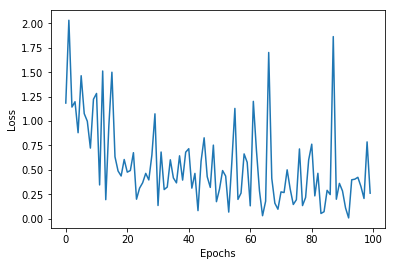

In [25]:
print_cm(confmat_emo,emotions)
print("-----------------------------------------------")
print(stats_emo)
print("Accuracy: %0.2f" % (acc_emo))
plt.plot(np.array(range(len(loss_history_emo))), loss_history_emo)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Now we authorize to update weights in a conv layer

In [20]:
model_conv2 = torchvision.models.inception_v3(pretrained='imagenet')
model_conv2.aux_logit=False

freeze_layers = True
n_class = len(get_label_quantity(prediction_labels_emo))
print("# class => ",n_class)

## Lets freeze the first few layers. This is done in two stages 
# Stage-1 Freezing all the layers 
if freeze_layers == True:
    for i, param in model_conv2.named_parameters():
        param.requires_grad = False

# Since imagenet as 1000 classes ,
#We need to change our last layer according to the number of classes we have,
num_ftrs = model_conv2.fc.in_features
model_conv2.fc = nn.Linear(num_ftrs, n_class)


# Stage-2 , Freeze all the layers but the one we want "Conv2d_4a_3*3"
for name, child in model_conv2.named_children():
    if "Conv2d_4a_3x3" == name:
        for params in child.parameters():
            params.requires_grad = True

    
# To view which layers are freeze and which layers are not freezed:
for name, child in model_conv2.named_children():
    print(name)
    for name_2, params in child.named_parameters():
        print(name_2, params.requires_grad)
    print('-' * 10)
    
print(model_conv2.fc.out_features)

# class =>  7
Conv2d_1a_3x3
conv.weight False
bn.weight False
bn.bias False
----------
Conv2d_2a_3x3
conv.weight False
bn.weight False
bn.bias False
----------
Conv2d_2b_3x3
conv.weight False
bn.weight False
bn.bias False
----------
Conv2d_3b_1x1
conv.weight False
bn.weight False
bn.bias False
----------
Conv2d_4a_3x3
conv.weight True
bn.weight True
bn.bias True
----------
Mixed_5b
branch1x1.conv.weight False
branch1x1.bn.weight False
branch1x1.bn.bias False
branch5x5_1.conv.weight False
branch5x5_1.bn.weight False
branch5x5_1.bn.bias False
branch5x5_2.conv.weight False
branch5x5_2.bn.weight False
branch5x5_2.bn.bias False
branch3x3dbl_1.conv.weight False
branch3x3dbl_1.bn.weight False
branch3x3dbl_1.bn.bias False
branch3x3dbl_2.conv.weight False
branch3x3dbl_2.bn.weight False
branch3x3dbl_2.bn.bias False
branch3x3dbl_3.conv.weight False
branch3x3dbl_3.bn.weight False
branch3x3dbl_3.bn.bias False
branch_pool.conv.weight False
branch_pool.bn.weight False
branch_pool.bn.bias False
------

branch3x3dbl_1.bn.weight False
branch3x3dbl_1.bn.bias False
branch3x3dbl_2.conv.weight False
branch3x3dbl_2.bn.weight False
branch3x3dbl_2.bn.bias False
branch3x3dbl_3a.conv.weight False
branch3x3dbl_3a.bn.weight False
branch3x3dbl_3a.bn.bias False
branch3x3dbl_3b.conv.weight False
branch3x3dbl_3b.bn.weight False
branch3x3dbl_3b.bn.bias False
branch_pool.conv.weight False
branch_pool.bn.weight False
branch_pool.bn.bias False
----------
fc
weight True
bias True
----------
7


In [23]:
epochs=100
#IF GPU
model_conv2.cuda()

criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model_conv2.parameters())
#optimizer = torch.optim.Adam(model_conv2.parameters(), 1.0, (0.9, 0.999), 1.0, 5e-05)
#optimizer = torch.optim.Adagrad(model_conv2.parameters(), 1.0, 0, 0.1,0)
#optimizer = torch.optim.ASGD(model_conv2.parameters(), 0.1, 0.0001, 0.75, 1000000.0, 0)
optimizer = torch.optim.Adadelta(model_conv2.parameters(), 1.0, 0.9, 1e-06, 5e-05)
#optimizer = torch.optim.SGD(model_conv2.parameters(),lr=1e-3, momentum=0.9, dampening=0)


classifier_emo2,loss_history_emo2 = trainClassifier(model_conv2,train_loader_emo_3D,test_loader_emo_3D,criterion,optimizer,epochs,True)

acc_emo2 = get_accuracy_batch(classifier_emo,test_loader_emo_3D)
confmat_emo2, stats_emo2 = get_stats_batch(classifier_emo,test_loader_emo_3D)

Epoch 1/100
----------
training -> Acc: 0.9740
testing -> Acc: 0.6875
Epoch 2/100
----------
training -> Acc: 0.9896
testing -> Acc: 0.6953
Epoch 3/100
----------
training -> Acc: 0.9844
testing -> Acc: 0.7188
Epoch 4/100
----------
training -> Acc: 0.9844
testing -> Acc: 0.6484
Epoch 5/100
----------
training -> Acc: 0.9844
testing -> Acc: 0.6719
Epoch 6/100
----------
training -> Acc: 0.9844
testing -> Acc: 0.7188
Epoch 7/100
----------
training -> Acc: 0.9896
testing -> Acc: 0.6328
Epoch 8/100
----------
training -> Acc: 0.9948
testing -> Acc: 0.6797
Epoch 9/100
----------
training -> Acc: 0.9844
testing -> Acc: 0.6875
Epoch 10/100
----------
training -> Acc: 0.9844
testing -> Acc: 0.7109
Epoch 11/100
----------
training -> Acc: 1.0000
testing -> Acc: 0.6953
Epoch 12/100
----------
training -> Acc: 0.9792
testing -> Acc: 0.6719
Epoch 13/100
----------
training -> Acc: 0.9948
testing -> Acc: 0.7344
Epoch 14/100
----------
training -> Acc: 0.9948
testing -> Acc: 0.6719
Epoch 15/100
--

       t/p      anger contempt  disgust     fear    happy  sadness surprise 
       anger        5        0        4        1        2        6        0 
    contempt        0        4        0        1        0        2        0 
     disgust        3        0       15        3        1        1        0 
        fear        0        0        0        4        2        1        3 
       happy        3        0        2        1       19        0        2 
     sadness        4        0        0        3        0        0        4 
    surprise        0        0        0        3        2        1       26 
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.33      0.28      0.30        18
           1       1.00      0.57      0.73         7
           2       0.71      0.65      0.68        23
           3       0.25      0.40      0.31        10
           4       0.73      0.70      0.72        27
           

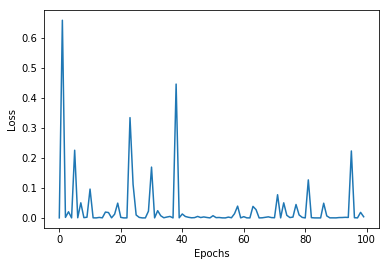

In [24]:
print_cm(confmat_emo2,emotions)
print("-----------------------------------------------")
print(stats_emo2)
print("Accuracy: %0.2f" % (acc_emo2))
plt.plot(np.array(range(len(loss_history_emo2))), loss_history_emo2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()